라이브러리

In [4]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



# 한글 글꼴 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 원하는 한글 글꼴 파일 경로로 수정해주세요
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

데이터셋 설정

In [5]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

In [6]:
#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [7]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training_tankAll = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation_tankAll = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

In [8]:
#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training_tankAll['mea_dt'] = pd.to_datetime(japonica_training_tankAll['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_tankAll['mea_dt'] = pd.to_datetime(japonica_validation_tankAll['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

In [9]:
# 날짜 데이터를 인덱스로 전환
japonica_training_tankAll.set_index('mea_dt', inplace=True)
japonica_validation_tankAll.set_index('mea_dt', inplace=True)

In [10]:
# 인덱스 순으로 데이터를 정렬
japonica_training_tankAll = japonica_training_tankAll.sort_index()
japonica_validation_tankAll = japonica_validation_tankAll.sort_index()

In [11]:
# 자포니카 훈련 및 검증 데이터의 각 탱크 번호
tank = 1
japonica_training_tank = japonica_training_tankAll[japonica_training_tankAll['tank_id']==tank]
japonica_validation_tank = japonica_validation_tankAll[japonica_validation_tankAll['tank_id']==tank]

In [12]:
# 사용할 features 선택
japonica_training_tank_features = japonica_training_tank[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_tank_features = japonica_validation_tank[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_tank_features = japonica_training_tank_features.fillna(0)
japonica_validation_tank_features = japonica_validation_tank_features.fillna(0)

In [13]:
# 독립 변수, 종속 변수 분리
japonica_training_tank_features_X = japonica_training_tank_features[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_tank_features_y = japonica_training_tank_features[['do_mg']]
japonica_validation_tank_features_X = japonica_validation_tank_features[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_tank_features_y = japonica_validation_tank_features[['do_mg']]

In [14]:
# LSTM학습을 위해 데이터 reshape를 해야함. reshape를 위해 배열형으로 변환
japonica_training_tank_features_X_reshape = np.asarray(japonica_training_tank_features_X, dtype=np.float64)
japonica_validation_tank_features_X_reshape = np.asarray(japonica_validation_tank_features_X, dtype=np.float64)

# 데이터를 3항으로 reshape. (batch_size, timesteps, features)
# batch_size: 한 번에 모델에 입력되는 샘플의 개수
# timesteps: 입력되는 시퀀스 데이터의 길이(시간축)
# features: 입력되는 데이터의 특성 개수
# 말이 어려우니까 쉽게 쓰면 (얼마 만큼의 샘플을, 시간 당 몇 개씩, 항목이 몇 개인가)
# (-1 : 있는 만큼의 샘플을, 1 : 시간당 1개씩, 8 : 피처는 8개입니다.)
japonica_training_tank_features_X_reshape = japonica_training_tank_features_X_reshape.reshape((-1, 1, 8))
japonica_validation_tank_features_X_reshape = japonica_validation_tank_features_X_reshape.reshape((-1, 1, 8))

In [15]:
# shape확인
nCar = japonica_training_tank_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_training_tank_features_X_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_tank_features_y.shape[0] # 데이터 개수
nVar = japonica_training_tank_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = japonica_validation_tank_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_validation_tank_features_X_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_tank_features_y.shape[0] # 데이터 개수
nVar = japonica_validation_tank_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 222751 nVar: 1
nCar: 222751 nVar: 1
nCar: 222751 nVar: 1
nCar: 222751 nVar: 1


In [25]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [14]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(1, 8), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            70144     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 132,001
Trainable params: 132,001
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_name = 'test230407-02_lstmJaponicaNomal.h5'

In [19]:
checkpoint = ModelCheckpoint('test230407-02_lstmJaponicaNomal.h5_best_model.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.

hist = model.fit(japonica_training_tank_features_X_reshape, japonica_training_tank_features_y, epochs = 200, batch_size = 64, validation_data=(japonica_validation_tank_features_X_reshape, japonica_validation_tank_features_y), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name)

Epoch 1/200
3481/3481 [==============================] - 21s 6ms/step - loss: 0.5745 - mae: 0.4849 - r_squared: 0.8048 - val_loss: 0.5920 - val_mae: 0.4966 - val_r_squared: -24.4162 - lr: 0.0010
Epoch 2/200
3481/3481 [==============================] - 21s 6ms/step - loss: 0.5753 - mae: 0.4848 - r_squared: 0.8038 - val_loss: 0.5268 - val_mae: 0.4688 - val_r_squared: -21.2484 - lr: 0.0010
Epoch 3/200
3481/3481 [==============================] - 21s 6ms/step - loss: 0.5767 - mae: 0.4845 - r_squared: 0.8035 - val_loss: 0.4862 - val_mae: 0.4451 - val_r_squared: -19.1945 - lr: 0.0010
Epoch 4/200
3481/3481 [==============================] - 21s 6ms/step - loss: 0.5685 - mae: 0.4817 - r_squared: 0.8063 - val_loss: 0.4842 - val_mae: 0.4439 - val_r_squared: -18.9411 - lr: 0.0010
Epoch 5/200
3481/3481 [==============================] - 21s 6ms/step - loss: 0.5678 - mae: 0.4811 - r_squared: 0.8067 - val_loss: 0.5839 - val_mae: 0.4821 - val_r_squared: -23.8185 - lr: 0.0010
Epoch 6/200
3481/3481 [==

모델 평가

In [24]:
# 모델 평가 함수
def grape(X_test, y_test, X_pred):
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(X_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(X_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('DO')
    plt.title('시계열')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
def eva(X_test_shape, y_test):
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test)
    print("MSE // MAE // R-squared ", result)

In [26]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name, custom_objects={'r_squared': r_squared})

[[ 2.9851262e-02  6.1694030e-02 -3.2043728e-01 ...  1.1787370e-01
   6.2358980e-03  9.6512932e-01]
 [ 3.2092731e-02  1.9770101e-01 -6.0044914e-01 ... -1.7496449e-03
   6.2130291e-02  1.2787572e+00]
 [-8.7943375e-02  8.3388105e-02 -1.1146112e-02 ...  2.0576099e-01
  -8.3927445e-02 -1.7965799e-02]
 ...
 [-6.4941913e-02 -6.1027341e-02 -3.5525861e-01 ... -4.0515214e-03
   6.7886241e-02  1.1804509e+00]
 [-6.0839102e-02 -8.4266670e-02  4.1457761e-02 ...  5.0948463e-02
  -7.0143268e-02  1.5189762e+00]
 [ 5.5400282e-04  2.7480002e-02  7.0904113e-02 ... -1.0667169e-01
  -4.1648928e-02  1.4957627e+00]]


c:\Users\rladn\anaconda3\envs\doRegressor\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


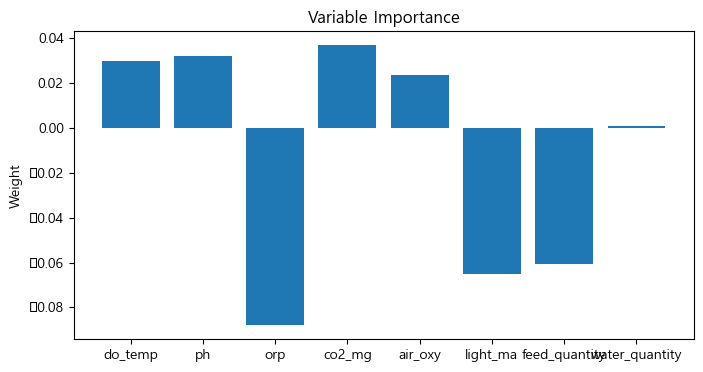

In [27]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(8), weights[:, 0])
ax.set_xticks(range(8))
ax.set_xticklabels(['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [28]:
# japonica_validation_tank_features_X_reshape 검증모델 예측
japonica_validation_tank_features_X_pred = model.predict(japonica_validation_tank_features_X_reshape)

6961/6961 [==============================] - 13s 2ms/step


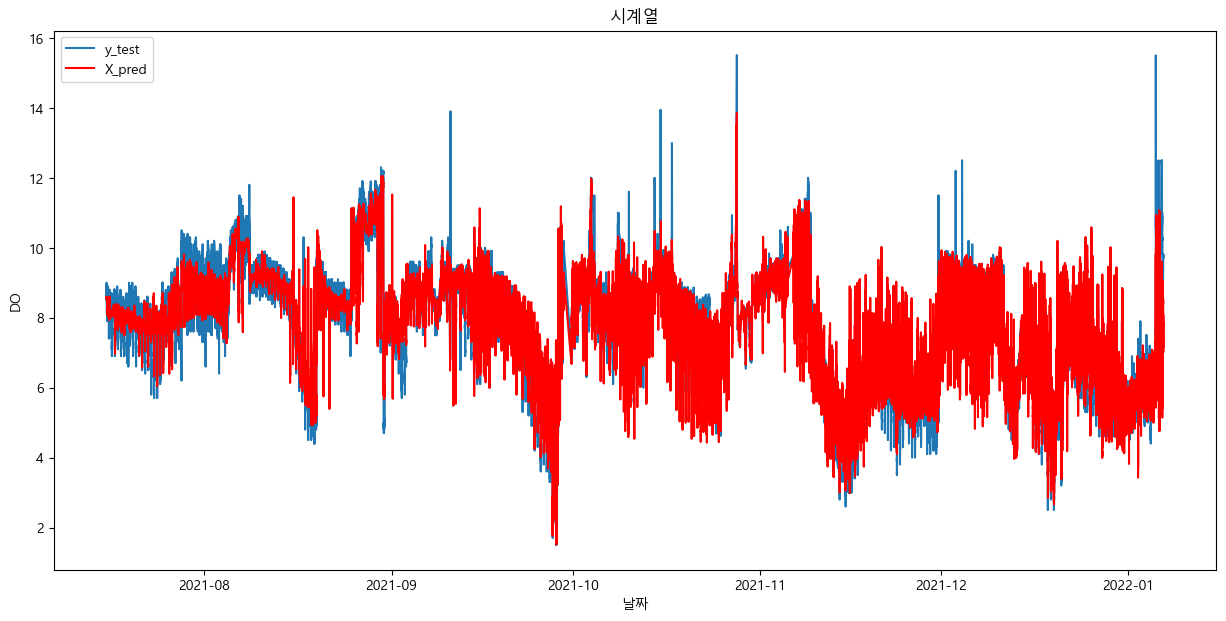

6961/6961 [==============================] - 14s 2ms/step - loss: 0.4166 - mae: 0.4084 - r_squared: -52.8182
MSE // MAE // R-squared  [0.4165780544281006, 0.4083751440048218, -52.81816101074219]


In [29]:
grape(japonica_validation_tank_features_X, japonica_validation_tank_features_y, japonica_validation_tank_features_X_pred)
eva(japonica_validation_tank_features_X_reshape, japonica_validation_tank_features_y)

In [30]:
# 하루 동안의 데이터 추출
one_day_data = japonica_validation_tank_features.loc['2021-08-28 00:00:00':'2021-08-28 23:59:59']
oneday_X_test = one_day_data[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, 8))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

oneday_pred = model.predict(oneday_X_test_reshape)

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1
45/45 [==============================] - 0s 2ms/step


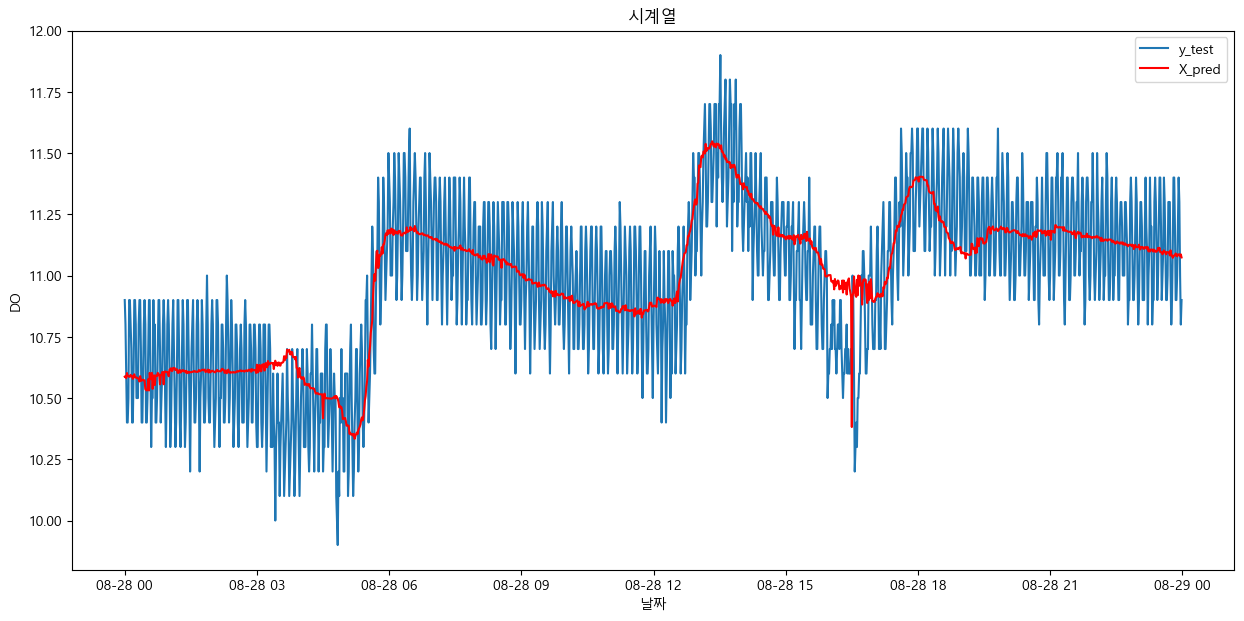

In [31]:
grape(oneday_X_test, oneday_y_test, oneday_pred)

In [32]:
japonica_training_tank['year_month_day'] = japonica_training_tank.index.strftime('%Y-%m-%d')  # 년월일만 추출
japonica_training_tank['hour_minute'] = japonica_training_tank.index.strftime('%H:%M')  # 시분만 추출
japonica_cross_tab_tank = pd.crosstab(index=japonica_training_tank['hour_minute'], columns=japonica_training_tank['year_month_day'], values=japonica_training_tank['do_mg'], aggfunc='sum')

japonica_cross_tab_tank

C:\Users\rladn\AppData\Local\Temp\ipykernel_22412\3694430873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_training_tank['year_month_day'] = japonica_training_tank.index.strftime('%Y-%m-%d')  # 년월일만 추출
C:\Users\rladn\AppData\Local\Temp\ipykernel_22412\3694430873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_training_tank['hour_minute'] = japonica_training_tank.index.strftime('%H:%M')  # 시분만 추출


year_month_day,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,2021-07-22,2021-07-23,2021-07-24,...,2021-12-28,2021-12-29,2021-12-30,2021-12-31,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06
hour_minute,,,,,,,,,,,,,,,,,,,,,
00:00,NaN,8.3,8.7,8.5,8.0,8.2,7.7,7.9,8.0,7.3,...,5.6,5.3,5.3,5.4,5.3,6.4,7.7,7.3,6.7,12.2
00:01,NaN,8.4,8.6,8.5,8.0,8.2,7.8,8.0,7.9,7.4,...,5.7,5.2,5.3,5.5,5.4,6.1,7.9,7.4,6.6,12.2
00:02,NaN,8.4,8.5,8.5,8.0,8.3,7.8,8.0,8.0,7.5,...,5.8,5.4,5.4,5.5,5.5,6.1,7.9,7.5,6.6,12.3
00:03,NaN,8.4,8.4,8.5,8.0,8.3,7.8,8.1,8.1,7.5,...,5.8,5.5,5.5,5.6,5.5,5.9,7.9,7.4,6.4,12.3
00:04,NaN,8.4,8.4,8.5,8.0,8.4,7.9,8.1,8.0,7.5,...,5.8,5.5,5.4,5.7,5.4,5.9,7.8,7.2,6.5,12.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:55,8.6,8.6,8.4,8.3,8.2,7.9,7.7,7.8,7.3,8.8,...,5.7,5.4,5.5,5.3,6.1,7.5,7.3,6.6,12.0,NaN
23:56,8.5,8.6,8.4,8.3,8.1,7.8,7.7,7.8,7.3,8.8,...,5.6,5.3,5.5,5.3,6.1,7.6,7.3,6.6,12.0,NaN
23:57,8.4,8.6,8.4,8.2,8.2,7.8,7.8,7.9,7.3,8.7,...,5.5,5.3,5.4,5.2,6.3,7.6,7.2,6.6,12.0,NaN
